In [1]:
import os
import random
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from PIL import Image

In [2]:
class NEUDETDatasetFolder(Dataset):
    def __init__(self, root_images_dir, transform=None):
        self.root_images_dir = root_images_dir
        self.transform = transform

        self.class_names = sorted([
            d for d in os.listdir(root_images_dir)
            if os.path.isdir(os.path.join(root_images_dir, d))
        ])
        if len(self.class_names) == 0:
            raise ValueError(f"Alt sınıf klasörü bulunamadı: {root_images_dir}")

        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}

        valid_ext = (".jpg", ".jpeg", ".png", ".bmp")
        self.samples = []
        for cls in self.class_names:
            cls_dir = os.path.join(root_images_dir, cls)
            for fname in os.listdir(cls_dir):
                fpath = os.path.join(cls_dir, fname)
                if os.path.isfile(fpath) and fname.lower().endswith(valid_ext):
                    self.samples.append((fpath, self.class_to_idx[cls]))

        if len(self.samples) == 0:
            raise ValueError(f"Hiç resim bulunamadı: {root_images_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])


In [4]:
train_images = "../train/images"
val_images = "../validation/images"

train_dataset = NEUDETDatasetFolder(train_images, transform=train_transform)
val_dataset = NEUDETDatasetFolder(val_images, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Classes:", train_dataset.class_names)


Train size: 1440
Val size: 360
Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [5]:
images, labels = next(iter(train_loader))
print("Images:", images.shape)
print("Labels:", labels[:10])

Images: torch.Size([32, 3, 224, 224])
Labels: tensor([4, 2, 0, 3, 3, 4, 5, 5, 0, 3])


In [6]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_classes = len(train_dataset.class_names)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze: tüm backbone'u dondur
for param in model.parameters():
    param.requires_grad = False

# Sadece son katmanı değiştir (classifier)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# Yeni eklenen classifier eğitilecek
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)
print("Model ready. Trainable params:", sum(p.requires_grad for p in model.parameters()))


Device: cpu
Model ready. Trainable params: 2


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)


In [8]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

In [9]:
num_epochs = 10  # şimdilik 10, sonra tuning yapacağız hocam
best_val_acc = 0.0
best_state = None

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc);   val_accs.append(va_acc)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch:02d} | Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | Val Loss {va_loss:.4f} Acc {va_acc:.4f}")

print("Best Val Acc:", best_val_acc)


Epoch 01 | Train Loss 1.0329 Acc 0.7174 | Val Loss 0.8093 Acc 0.7694
Epoch 02 | Train Loss 0.3832 Acc 0.9535 | Val Loss 0.4396 Acc 0.8750
Epoch 03 | Train Loss 0.2461 Acc 0.9681 | Val Loss 0.3469 Acc 0.9083
Epoch 04 | Train Loss 0.1762 Acc 0.9736 | Val Loss 0.2901 Acc 0.9250
Epoch 05 | Train Loss 0.1649 Acc 0.9701 | Val Loss 0.2565 Acc 0.9361
Epoch 06 | Train Loss 0.1549 Acc 0.9688 | Val Loss 0.2094 Acc 0.9528
Epoch 07 | Train Loss 0.1217 Acc 0.9778 | Val Loss 0.1708 Acc 0.9667
Epoch 08 | Train Loss 0.1192 Acc 0.9715 | Val Loss 0.2165 Acc 0.9389
Epoch 09 | Train Loss 0.1017 Acc 0.9778 | Val Loss 0.1659 Acc 0.9556
Epoch 10 | Train Loss 0.0906 Acc 0.9833 | Val Loss 0.1531 Acc 0.9528
Best Val Acc: 0.9666666666666667


In [10]:
model.load_state_dict(best_state)
model = model.to(device)
print("Loaded best model weights.")

Loaded best model weights.


In [11]:
import numpy as np

@torch.no_grad()
def get_preds_labels(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for images, labels in loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()

        all_preds.append(preds)
        all_labels.append(labels.numpy())

    return np.concatenate(all_preds), np.concatenate(all_labels)

y_pred, y_true = get_preds_labels(model, val_loader, device)
print("Pred/True shapes:", y_pred.shape, y_true.shape)

Pred/True shapes: (360,) (360,)


In [12]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)

print("VAL(TEST) Metrics")
print(f"Accuracy:        {acc:.4f}")
print(f"Macro Precision: {prec:.4f}")
print(f"Macro Recall:    {rec:.4f}")
print(f"Macro F1-score:  {f1:.4f}")

VAL(TEST) Metrics
Accuracy:        0.9667
Macro Precision: 0.9683
Macro Recall:    0.9667
Macro F1-score:  0.9661


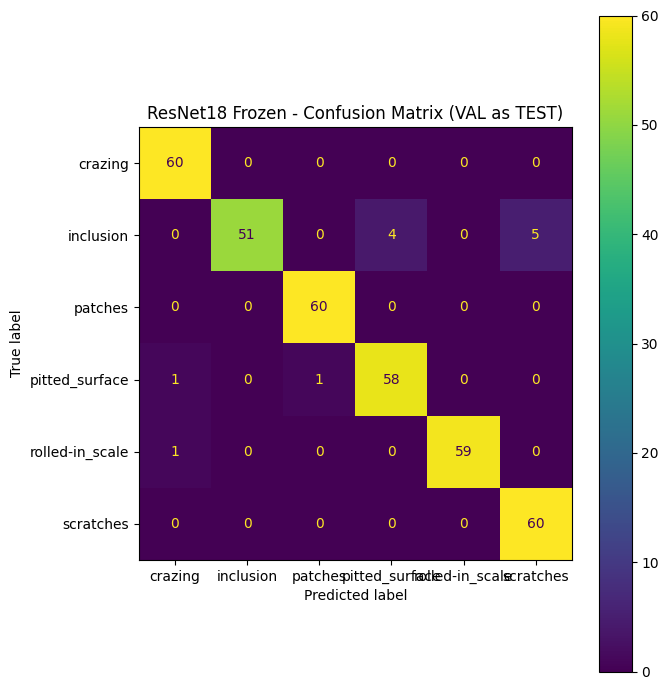

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.class_names)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax, values_format="d")
plt.title("ResNet18 Frozen - Confusion Matrix (VAL as TEST)")
plt.tight_layout()
plt.savefig("resnet18_frozen_confusion_matrix.png", dpi=300)
plt.show()

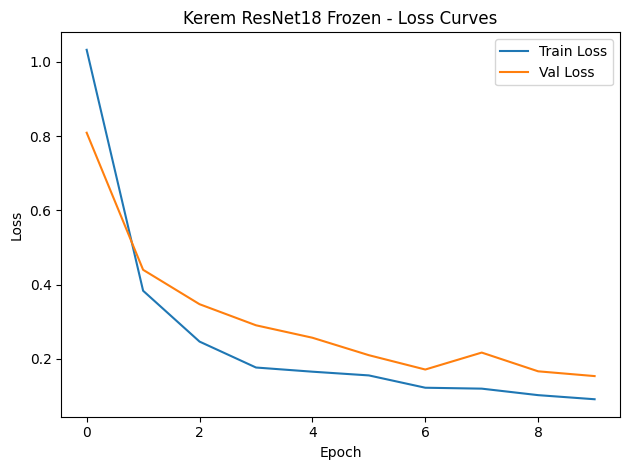

In [14]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Kerem ResNet18 Frozen - Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("resnet18_frozen_loss_curves.png", dpi=300)
plt.show()


In [15]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.class_names)

ft_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# önce hepsini dondur
for p in ft_model.parameters():
    p.requires_grad = False

# classifier değiştir
ft_model.fc = nn.Linear(ft_model.fc.in_features, num_classes)

# frozen eğitimden gelen en iyi fc ağırlıklarını yükleyelim (warm start)
# (shape uyduğu için direkt yüklenir)
state = best_state.copy()
# sadece fc katmanları uygun; diğerleri pretrained kalabilir
ft_model.load_state_dict(state, strict=False)

ft_model = ft_model.to(device)


In [16]:
# Son blok (layer4) + fc aç
for p in ft_model.layer4.parameters():
    p.requires_grad = True
for p in ft_model.fc.parameters():
    p.requires_grad = True

criterion = nn.CrossEntropyLoss()

# Fine-tune: düşük LR
optimizer = optim.Adam(
    [
        {"params": ft_model.layer4.parameters(), "lr": 1e-4},
        {"params": ft_model.fc.parameters(), "lr": 5e-4},
    ]
)


In [17]:
ft_epochs = 8
best_val_acc_ft = 0.0
best_state_ft = None

ft_train_losses, ft_val_losses = [], []
ft_train_accs, ft_val_accs = [], []

for epoch in range(1, ft_epochs + 1):
    tr_loss, tr_acc = train_one_epoch(ft_model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(ft_model, val_loader, criterion, device)

    ft_train_losses.append(tr_loss); ft_val_losses.append(va_loss)
    ft_train_accs.append(tr_acc);   ft_val_accs.append(va_acc)

    if va_acc > best_val_acc_ft:
        best_val_acc_ft = va_acc
        best_state_ft = {k: v.cpu().clone() for k, v in ft_model.state_dict().items()}

    print(f"[FT] Epoch {epoch:02d} | Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | Val Loss {va_loss:.4f} Acc {va_acc:.4f}")

print("Best Val Acc (FT):", best_val_acc_ft)


[FT] Epoch 01 | Train Loss 0.0677 Acc 0.9799 | Val Loss 0.0396 Acc 0.9889
[FT] Epoch 02 | Train Loss 0.0217 Acc 0.9931 | Val Loss 0.0164 Acc 0.9944
[FT] Epoch 03 | Train Loss 0.0122 Acc 0.9979 | Val Loss 0.0043 Acc 1.0000
[FT] Epoch 04 | Train Loss 0.0136 Acc 0.9958 | Val Loss 0.0211 Acc 0.9917
[FT] Epoch 05 | Train Loss 0.0069 Acc 0.9979 | Val Loss 0.0348 Acc 0.9889
[FT] Epoch 06 | Train Loss 0.0043 Acc 0.9986 | Val Loss 0.0243 Acc 0.9833
[FT] Epoch 07 | Train Loss 0.0061 Acc 0.9979 | Val Loss 0.0047 Acc 0.9972
[FT] Epoch 08 | Train Loss 0.0077 Acc 0.9972 | Val Loss 0.0112 Acc 0.9944
Best Val Acc (FT): 1.0


In [18]:
ft_model.load_state_dict(best_state_ft)
ft_model = ft_model.to(device)

y_pred_ft, y_true_ft = get_preds_labels(ft_model, val_loader, device)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

acc_ft = accuracy_score(y_true_ft, y_pred_ft)
prec_ft, rec_ft, f1_ft, _ = precision_recall_fscore_support(
    y_true_ft, y_pred_ft, average="macro", zero_division=0
)

print("VAL(TEST) Metrics - ResNet18 FineTune")
print(f"Accuracy:        {acc_ft:.4f}")
print(f"Macro Precision: {prec_ft:.4f}")
print(f"Macro Recall:    {rec_ft:.4f}")
print(f"Macro F1-score:  {f1_ft:.4f}")


VAL(TEST) Metrics - ResNet18 FineTune
Accuracy:        1.0000
Macro Precision: 1.0000
Macro Recall:    1.0000
Macro F1-score:  1.0000


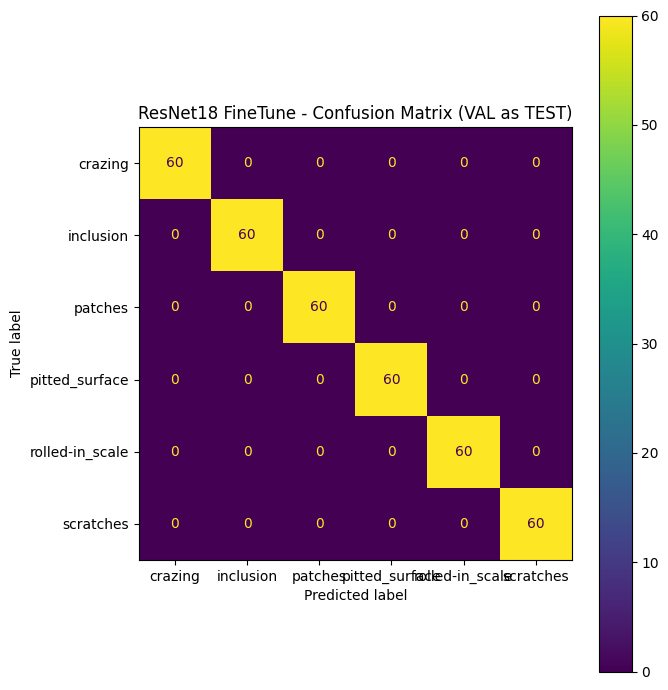

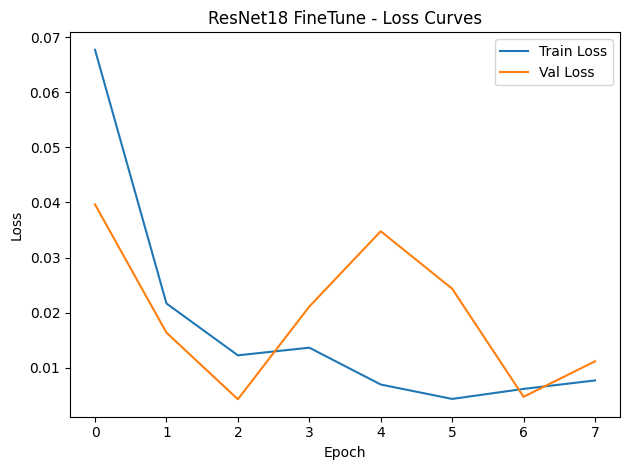

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_ft = confusion_matrix(y_true_ft, y_pred_ft)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_ft, display_labels=train_dataset.class_names)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax, values_format="d")
plt.title("ResNet18 FineTune - Confusion Matrix (VAL as TEST)")
plt.tight_layout()
plt.savefig("resnet18_finetune_confusion_matrix.png", dpi=300)
plt.show()

plt.figure()
plt.plot(ft_train_losses, label="Train Loss")
plt.plot(ft_val_losses, label="Val Loss")
plt.title("ResNet18 FineTune - Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("resnet18_finetune_loss_curves.png", dpi=300)
plt.show()


In [22]:
import numpy as np
import torch
from sklearn.metrics import classification_report

model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("ResNet18 Frozen")
print(classification_report(
    y_true, y_pred,
    target_names=train_dataset.class_names,
    digits=4
))


ResNet18 Frozen
                 precision    recall  f1-score   support

        crazing     0.9677    1.0000    0.9836        60
      inclusion     1.0000    0.8500    0.9189        60
        patches     0.9836    1.0000    0.9917        60
 pitted_surface     0.9355    0.9667    0.9508        60
rolled-in_scale     1.0000    0.9833    0.9916        60
      scratches     0.9231    1.0000    0.9600        60

       accuracy                         0.9667       360
      macro avg     0.9683    0.9667    0.9661       360
   weighted avg     0.9683    0.9667    0.9661       360



In [23]:
import numpy as np
import torch
from sklearn.metrics import classification_report

ft_model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = ft_model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("ResNet18 Fine-tune")
print(classification_report(
    y_true, y_pred,
    target_names=train_dataset.class_names,
    digits=4
))


ResNet18 Fine-tune
                 precision    recall  f1-score   support

        crazing     1.0000    1.0000    1.0000        60
      inclusion     1.0000    1.0000    1.0000        60
        patches     1.0000    1.0000    1.0000        60
 pitted_surface     1.0000    1.0000    1.0000        60
rolled-in_scale     1.0000    1.0000    1.0000        60
      scratches     1.0000    1.0000    1.0000        60

       accuracy                         1.0000       360
      macro avg     1.0000    1.0000    1.0000       360
   weighted avg     1.0000    1.0000    1.0000       360

